In [8]:
import matplotlib.pyplot as plt

In [9]:
data= datasets.load_wine()

In [13]:
from sklearn import datasets
data = datasets.load_diabetes()

features_in_different_scale = True

if features_in_different_scale:
    data["data"][:, 0] = 100*data["data"][:, 0]
    data["data"][:, 1] = 10*data["data"][:, 1]
    data["data"][:, 2] = 0.01*data["data"][:, 2]
    data["data"][:, 3] = 10000*data["data"][:, 3]


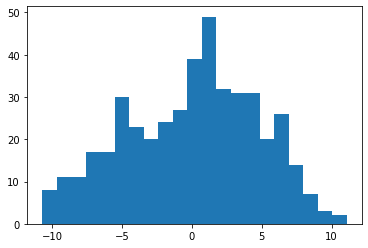

In [14]:
plt.hist(data["data"][:, 0], bins=21);

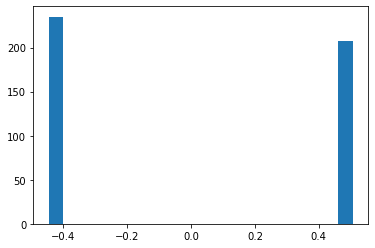

In [15]:
plt.hist(data["data"][:, 1], bins=21);

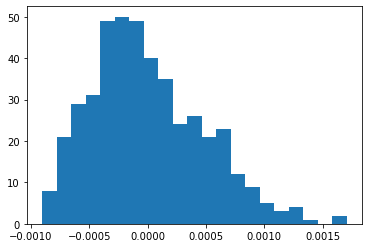

In [16]:
plt.hist(data["data"][:, 2], bins=21);

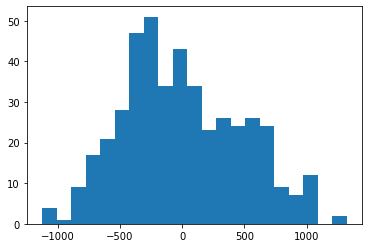

In [17]:
plt.hist(data["data"][:, 3], bins=21);

In [18]:
import torch

class QuantizeFeaturesStub(torch.nn.Module):
    def __init__(self, num_feats):
        super().__init__()
        self.num_feats = num_feats
        self.quants = torch.nn.ModuleList()
        for ifeat in range(self.num_feats):
            self.quants.append(torch.ao.quantization.QuantStub())

    def forward(self, x):
        return torch.cat([self.quants[ifeat](x[..., ifeat:ifeat+1]) for ifeat in range(self.num_feats)], axis=-1)
                 
# define a floating point model where some layers could be statically quantized
class M(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # QuantStub converts tensors from floating point to quantized
        
        self.quant = QuantizeFeaturesStub(10)
        self.lin1 = torch.nn.Linear(10, 128) #10 input features
        self.relu = torch.nn.ReLU()
        self.lin2 = torch.nn.Linear(128, 1) #1 regression output
        # DeQuantStub converts tensors from quantized to floating point
        self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x):
        # manually specify where tensors will be converted from floating
        # point to quantized in the quantized model
        x = self.quant(x)
        x = self.lin1(x)
        x = self.relu(x)
        x = self.lin2(x)
        # manually specify where tensors will be converted from quantized
        # to floating point in the quantized model
        x = self.dequant(x)
        return x

In [19]:
model_fp32 = M()
optimizer = torch.optim.AdamW(model_fp32.parameters(), lr=0.005)
for epoch in range(2000):
    optimizer.zero_grad()
    out = model_fp32(torch.tensor(data["data"]).to(dtype=torch.float))
    loss = torch.nn.functional.mse_loss(out[:, 0], torch.tensor(data["target"]).to(torch.float))
    loss.backward()
    if epoch%100 == 0:
        print(epoch, loss.detach().cpu().item())
    optimizer.step()

0 27401.22265625
100 10792.828125
200 9138.3291015625
300 6686.6171875
400 5563.88720703125
500 4555.40869140625
600 3913.210693359375
700 3551.58544921875
800 3443.60595703125
900 3367.0712890625
1000 3289.8212890625
1100 3296.051513671875
1200 3190.966796875
1300 3162.62890625
1400 3136.28515625
1500 3135.9697265625
1600 3100.529296875
1700 3087.234619140625
1800 3080.088623046875
1900 3065.173095703125


In [20]:
import matplotlib.pyplot as plt

In [21]:
out = model_fp32(torch.tensor(data["data"]).to(torch.float)).detach().cpu().numpy()[:, 0]

(0.0, 400.0)

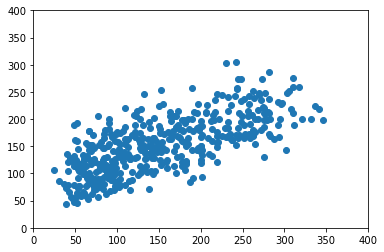

In [22]:
plt.scatter(data["target"], out)
plt.xlim(0,400)
plt.ylim(0,400)

In [24]:
# model must be set to eval mode for static quantization logic to work
model_fp32.eval()

# attach a global qconfig, which contains information about what kind
# of observers to attach. Use 'x86' for server inference and 'qnnpack'
# for mobile inference. Other quantization configurations such as selecting
# symmetric or asymmetric quantization and MinMax or L2Norm calibration techniques
# can be specified here.
# Note: the old 'fbgemm' is still available but 'x86' is the recommended default
# for server inference.
# model_fp32.qconfig = torch.ao.quantization.get_default_qconfig('fbgemm')

# model_fp32.qconfig = torch.ao.quantization.get_default_qconfig("onednn", version=1)
model_fp32.qconfig = torch.ao.quantization.qconfig_mapping.get_default_qat_qconfig_mapping(backend='x86', version=1)
# Fuse the activations to preceding layers, where applicable.
# This needs to be done manually depending on the model architecture.
# Common fusions include `conv + relu` and `conv + batchnorm + relu`
#model_fp32_fused = torch.ao.quantization.fuse_modules(model_fp32, [])

# Prepare the model for static quantization. This inserts observers in
# the model that will observe activation tensors during calibration.
model_fp32_prepared = torch.ao.quantization.prepare(model_fp32)

input_fp32 = torch.tensor(data["data"]).to(torch.float)

# calibrate the prepared model to determine quantization parameters for activations
# in a real world setting, the calibration would be done with a representative dataset
model_fp32_prepared(input_fp32)

# Convert the observed model to a quantized model. This does several things:
# quantizes the weights, computes and stores the scale and bias value to be
# used with each activation tensor, and replaces key operators with quantized
# implementations.
model_int8 = torch.ao.quantization.convert(model_fp32_prepared)

# run the model, relevant calculations will happen in int8
out_quantized = model_int8(input_fp32)[:, 0]

AttributeError: 'QConfigMapping' object has no attribute '_fields'

In [34]:
model_fp32.qconfig

QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=False){}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})

In [35]:
input_fp32.shape

torch.Size([442, 10])

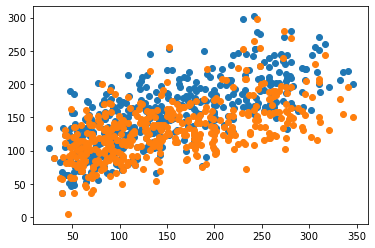

In [36]:
plt.scatter(data["target"], out)
plt.scatter(data["target"], out_quantized)

In [22]:
model_int8.quant

QuantizeFeaturesStub(
  (quants): ModuleList(
    (0): Quantize(scale=tensor([0.0009]), zero_point=tensor([126]), dtype=torch.quint8)
    (1): Quantize(scale=tensor([0.0004]), zero_point=tensor([119]), dtype=torch.quint8)
    (2): Quantize(scale=tensor([0.0010]), zero_point=tensor([88]), dtype=torch.quint8)
    (3): Quantize(scale=tensor([0.0010]), zero_point=tensor([117]), dtype=torch.quint8)
    (4): Quantize(scale=tensor([0.0011]), zero_point=tensor([115]), dtype=torch.quint8)
    (5): Quantize(scale=tensor([0.0012]), zero_point=tensor([94]), dtype=torch.quint8)
    (6): Quantize(scale=tensor([0.0011]), zero_point=tensor([92]), dtype=torch.quint8)
    (7): Quantize(scale=tensor([0.0010]), zero_point=tensor([74]), dtype=torch.quint8)
    (8): Quantize(scale=tensor([0.0010]), zero_point=tensor([124]), dtype=torch.quint8)
    (9): Quantize(scale=tensor([0.0011]), zero_point=tensor([129]), dtype=torch.quint8)
  )
)

In [15]:
x1 = model_int8.quant(input_fp32)
x1

tensor([[ 3.7737,  0.5146,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1715, -0.5146,  0.0000,  ...,  0.0000,  0.0000, -0.1715],
        [ 8.5766,  0.5146,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 4.1168,  0.5146,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-4.6314, -0.5146,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-4.6314, -0.5146,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       size=(442, 10), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.17153218388557434,
       zero_point=63)

In [16]:
model_int8.lin1

QuantizedLinear(in_features=10, out_features=128, scale=6.321656227111816, zero_point=68, qscheme=torch.per_channel_affine)

In [17]:
x2 = model_int8.lin1(x1)
x2

tensor([[  0.0000,  -6.3217,   0.0000,  ..., -12.6433,   0.0000,   6.3217],
        [  6.3217,   0.0000,   0.0000,  ...,   6.3217,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,  12.6433],
        ...,
        [  0.0000,  -6.3217,   0.0000,  ..., -12.6433,   0.0000,   6.3217],
        [  6.3217,  -6.3217,   0.0000,  ...,   0.0000,  -6.3217,   0.0000],
        [  6.3217,   0.0000,   0.0000,  ...,   6.3217,   0.0000,   0.0000]],
       size=(442, 128), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=6.321656227111816,
       zero_point=68)

In [18]:
x3 = model_int8.relu(x2)
x3

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  6.3217],
        [ 6.3217,  0.0000,  0.0000,  ...,  6.3217,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, 12.6433],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  6.3217],
        [ 6.3217,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 6.3217,  0.0000,  0.0000,  ...,  6.3217,  0.0000,  0.0000]],
       size=(442, 128), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=6.321656227111816,
       zero_point=68)

In [19]:
model_int8.lin2

QuantizedLinear(in_features=128, out_features=1, scale=2.3833446502685547, zero_point=0, qscheme=torch.per_channel_affine)

In [20]:
x4 = model_int8.lin2(x3)
x4[:10]

tensor([[ 88.1838],
        [143.0007],
        [112.0172],
        [128.7006],
        [166.8341],
        [114.4005],
        [ 85.8004],
        [ 88.1838],
        [107.2505],
        [133.4673]], size=(10, 1), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=2.3833446502685547,
       zero_point=0)

In [21]:
model_int8.dequant

DeQuantize()

In [22]:
x5 = model_int8.dequant(x4)

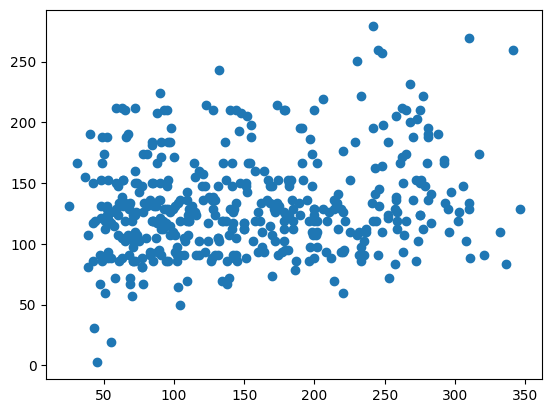

In [23]:
plt.scatter(data["target"], x5[:, 0])